# SHAP

## SHAP preprocess

In [1]:
import warnings
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from interpret import show
import interpret.glassbox

pd.set_option('display.float_format', lambda x: '%.7f' % x)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
file_loc =  os.getcwd()
file_dir = ['/BPIC11/','/BPIC12/','/BPIC15/','/SEPSIS/']
file_tag = ['BPIC11','BPIC12','BPIC15','SEPSIS']
indep_var = ['Sequence', 'Event', 'Time', 'Init+Actf', 'Models', 'NoLayer','NoHidden']
colors_bin = sns.color_palette("colorblind", len(file_dir))

In [2]:
def shap_val(df_c):
    X = df_c.loc[:,['Sequence', 'Event', 'Time', 'Models', 'NoLayer','NoHidden', 'Init+Actf']]
    Y = df_c.AUC.values
    model = interpret.glassbox.ExplainableBoostingRegressor(interactions=0,random_state=42)
    model.fit(X, Y)
    explainer = shap.Explainer(model.predict,X)
    shap_values = explainer(X)
    return shap_values

In [3]:
def df_concat_maker(fd_):
    file_list = os.listdir(file_loc+str(fd_))
    df_list = []
    df_ = pd.DataFrame()

    for i in file_list:
        with open(file=(file_loc+str(fd_)+str(i)), mode='rb') as f:
            df =pickle.load(f)
        df=df[['Sequence', 'Event', 'Time', 'Models', 'NoLayer','NoHidden', 'Init+Actf','AUC_ovr']]
        df.columns = ['Sequence', 'Event', 'Time', 'Models', 'NoLayer','NoHidden', 'Init+Actf','AUC']
        cate_map = {}
        col_co = 0
        for col in ['Sequence', 'Event', 'Time', 'Models', 'Init+Actf']:
            df[col] = df[col].astype('category')
            cate_map[col] = {index+col_co: category for index, category in enumerate(df[col].cat.categories)}
            df[col] = df[col].cat.codes
            df[col] = df[col] + col_co
            col_co+= df[col].nunique()
        df_ = pd.concat([df_,df], sort=False)

    return df_,cate_map

In [4]:
shap_bin_abs = []
shap_bin_ = []
dfc_list = []
pre_cate = None
for fd in file_dir:
  df_concat,cate_dict = df_concat_maker(fd)
  df_concat = df_concat.drop_duplicates()
  shap_bin_abs.append(list(np.mean(np.abs(shap_val(df_concat).values),axis=0)))
  shap_bin_.append(shap_val(df_concat))
  if pre_cate is not None:
      if pre_cate == cate_dict:
          pass
      else:
          raise Exception("Dict is different")
          break
  pre_cate = cate_dict
  dfc_list.append(df_concat)
categorical = {}
for sub_dict in cate_dict.values():
    categorical.update(sub_dict)


{0: 'cont', 1: 'prfx', 2: 'se', 3: 'emb', 4: 'frq', 5: 'oh', 6: 'all', 7: 'none', 8: 'tssc_tsp', 9: 'lstm', 10: 'mlp', 11: 'default+none', 12: 'he+relu', 13: 'xav+tanh'}


In [5]:
print('BPIC11: ',len(shap_bin_[0]),'\nBPIC12: ', len(shap_bin_[1]),'\nBPIC15: ',len(shap_bin_[2]),'\nSEPSIS: ',len(shap_bin_[3]))

BPIC11:  157 
BPIC12:  190 
BPIC15:  172 
SEPSIS:  176


## Mean Abs SHAP

In [6]:
abs_dict = {}
abs_dict['BPIC11'] = shap_bin_abs[0]
abs_dict['BPIC12'] = shap_bin_abs[1]
abs_dict['BPIC15'] = shap_bin_abs[2]
abs_dict['SEPSIS'] = shap_bin_abs[3]
df_abs = pd.DataFrame(abs_dict, index=['SEQE', 'EE', 'TF', 'MOD', 'NLA', 'LAS', 'AFI'])
df_abs

,BPIC11,BPIC12,BPIC15,SEPSIS
SEQE,0.0051354,0.0028476,0.0011722,0.0103780
EE,0.0009923,0.0006145,0.0189425,0.0021200
TF,0.0026565,0.0010787,0.0011490,0.0074984
MOD,0.0029572,0.0022688,0.0020468,0.0151220
NLA,0.0005531,0.0001075,0.0016173,0.0015949
LAS,0.0018781,0.0002509,0.0004612,0.0028153
AFI,0.0039884,0.0033355,0.0023401,0.0028582


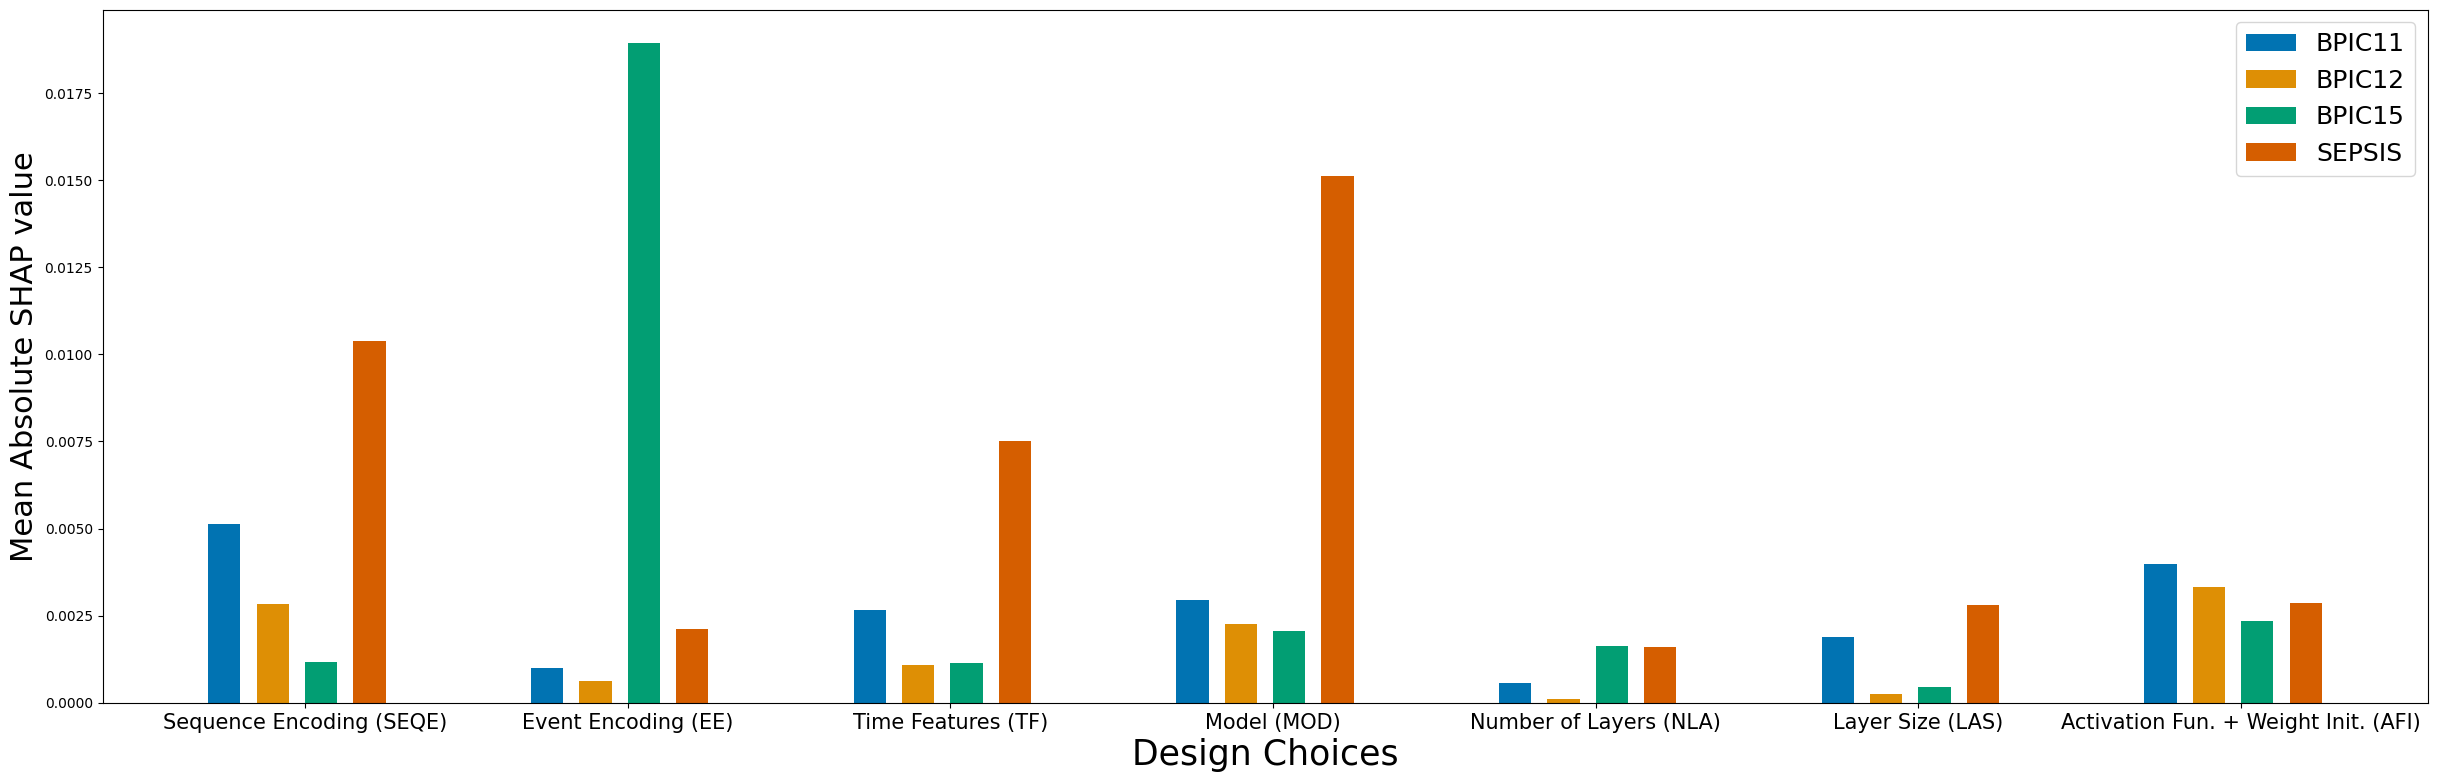

In [7]:
fig, ax = plt.subplots(figsize=(30,9))
bar_width = 0.1
col_name = ['Sequence Encoding (SEQE)', 'Event Encoding (EE)', 'Time Features (TF)',
            'Model (MOD)','Number of Layers (NLA)', 'Layer Size (LAS)', 'Activation Fun. + Weight Init. (AFI)']
index = np.arange(len(col_name))

for i in range(len(file_dir)):

    if i == 0:
        plt.bar(index + bar_width+0.1, shap_bin_abs[i], bar_width, alpha=1, color=colors_bin[i], label=file_tag[i])
    elif i==1:
        plt.bar(index + bar_width+0.25, shap_bin_abs[i], bar_width, alpha=1, color=colors_bin[i], label=file_tag[i])
    elif i==2:
        plt.bar(index + bar_width+0.4, shap_bin_abs[i], bar_width, alpha=1, color=colors_bin[i], label=file_tag[i])
    else:
        plt.bar(index + bar_width+0.55, shap_bin_abs[i], bar_width, alpha=1, color=colors_bin[i], label=file_tag[i])

plt.xticks(np.arange(bar_width+0.35, len(col_name)+ bar_width, 1), col_name,fontsize="15") # 4 or
plt.xlabel('Design Choices', size = 25)
plt.ylabel('Mean Absolute SHAP value', size = 22)
plt.legend(fontsize="18")
plt.show()

## SHAP value for individual 

In [8]:
shap_data_bin = []
for sl in shap_bin_:
    shap_by_log = {}
    for sb,dt in zip(sl.values, sl.data):
        for idx,(s,d) in enumerate(zip(sb,dt)):
            if idx == 4:
                if f'NoLayer: {d}' not in shap_by_log:
                    shap_by_log[f'NoLayer: {d}'] = s
                else:
                    if round(shap_by_log[f'NoLayer: {d}'],6) != round(s,6):
                        raise Exception("Value not matched")
            elif idx == 5:
                if f'NoLayer: {d}' not in shap_by_log:
                    shap_by_log[f'NoHidden: {d}'] = s
                else:
                    if round(shap_by_log[f'NoHidden: {d}'],6) != round(s,6):
                        raise Exception("Value not matched")
            else:
                if categorical[d] not in shap_by_log:
                    shap_by_log[categorical[d]] = s
                else:
                    if round(shap_by_log[categorical[d]],6) != round(s,6):
                        raise Exception("Value not matched")
    num_uniq = 0
    for i in range(sl.data.shape[1]):
        num_uniq+= np.unique(sl.data[:,i]).shape[0]
    if num_uniq != len(shap_by_log.keys()):
        raise Exception("Dict key not matched")
    shap_data_bin.append(shap_by_log)


In [9]:
df_bpic11 = pd.DataFrame(shap_data_bin[0], index=['BPIC11']).T
df_bpic12 = pd.DataFrame(shap_data_bin[1], index=['BPIC12']).T
df_bpic15 = pd.DataFrame(shap_data_bin[2], index=['BPIC15']).T
df_sepsis = pd.DataFrame(shap_data_bin[3], index=['SEPSIS']).T

df_combined = pd.concat([df_bpic11, df_bpic12, df_bpic15, df_sepsis], axis=1)
new_index_order = [
    'cont', 'prfx', 'se', 'emb', 'oh', 'frq', 'all', 'tssc_tsp', 'none',
    'lstm', 'mlp', 'NoLayer: 2', 'NoLayer: 3', 'NoHidden: 32', 'NoHidden: 64',
    'NoHidden: 128', 'xav+tanh', 'he+relu', 'default+none'
]

df_combined = df_combined.reindex(new_index_order)
df_combined.index = ['SEQE: CO','SEQE: PP','SEQE: SE','EE: EM','EE: OH','EE: FB', 'TF: ALL','TF: TST','TF: NONE','MOD: LSTM','MOD: MLP','NLA: 2','NLA: 3','LAS: 32','LAS: 64','LAS: 128','AFI: TX','AFI: HR','AFI: DN']
df_combined

,BPIC11,BPIC12,BPIC15,SEPSIS
SEQE: CO,0.0031573,0.0034184,0.0022491,0.0035400
SEQE: PP,-0.0133970,-0.0005898,-0.0011132,0.0068819
SEQE: SE,0.0034315,-0.0073464,-0.0001172,-0.0354325
EE: EM,0.0002985,0.0008907,-0.0426275,0.0013739
EE: OH,-0.0020928,-0.0006963,-0.0081924,-0.0026540
EE: FB,0.0008643,0.0002271,0.0167823,0.0022693
TF: ALL,0.0020113,0.0013270,0.0008788,0.0054275
TF: TST,0.0015369,0.0004273,0.0010058,0.0036904
TF: NONE,-0.0053887,-0.0016953,-0.0014918,-0.0192245
MOD: LSTM,0.0030190,0.0018378,0.0025153,0.0115153


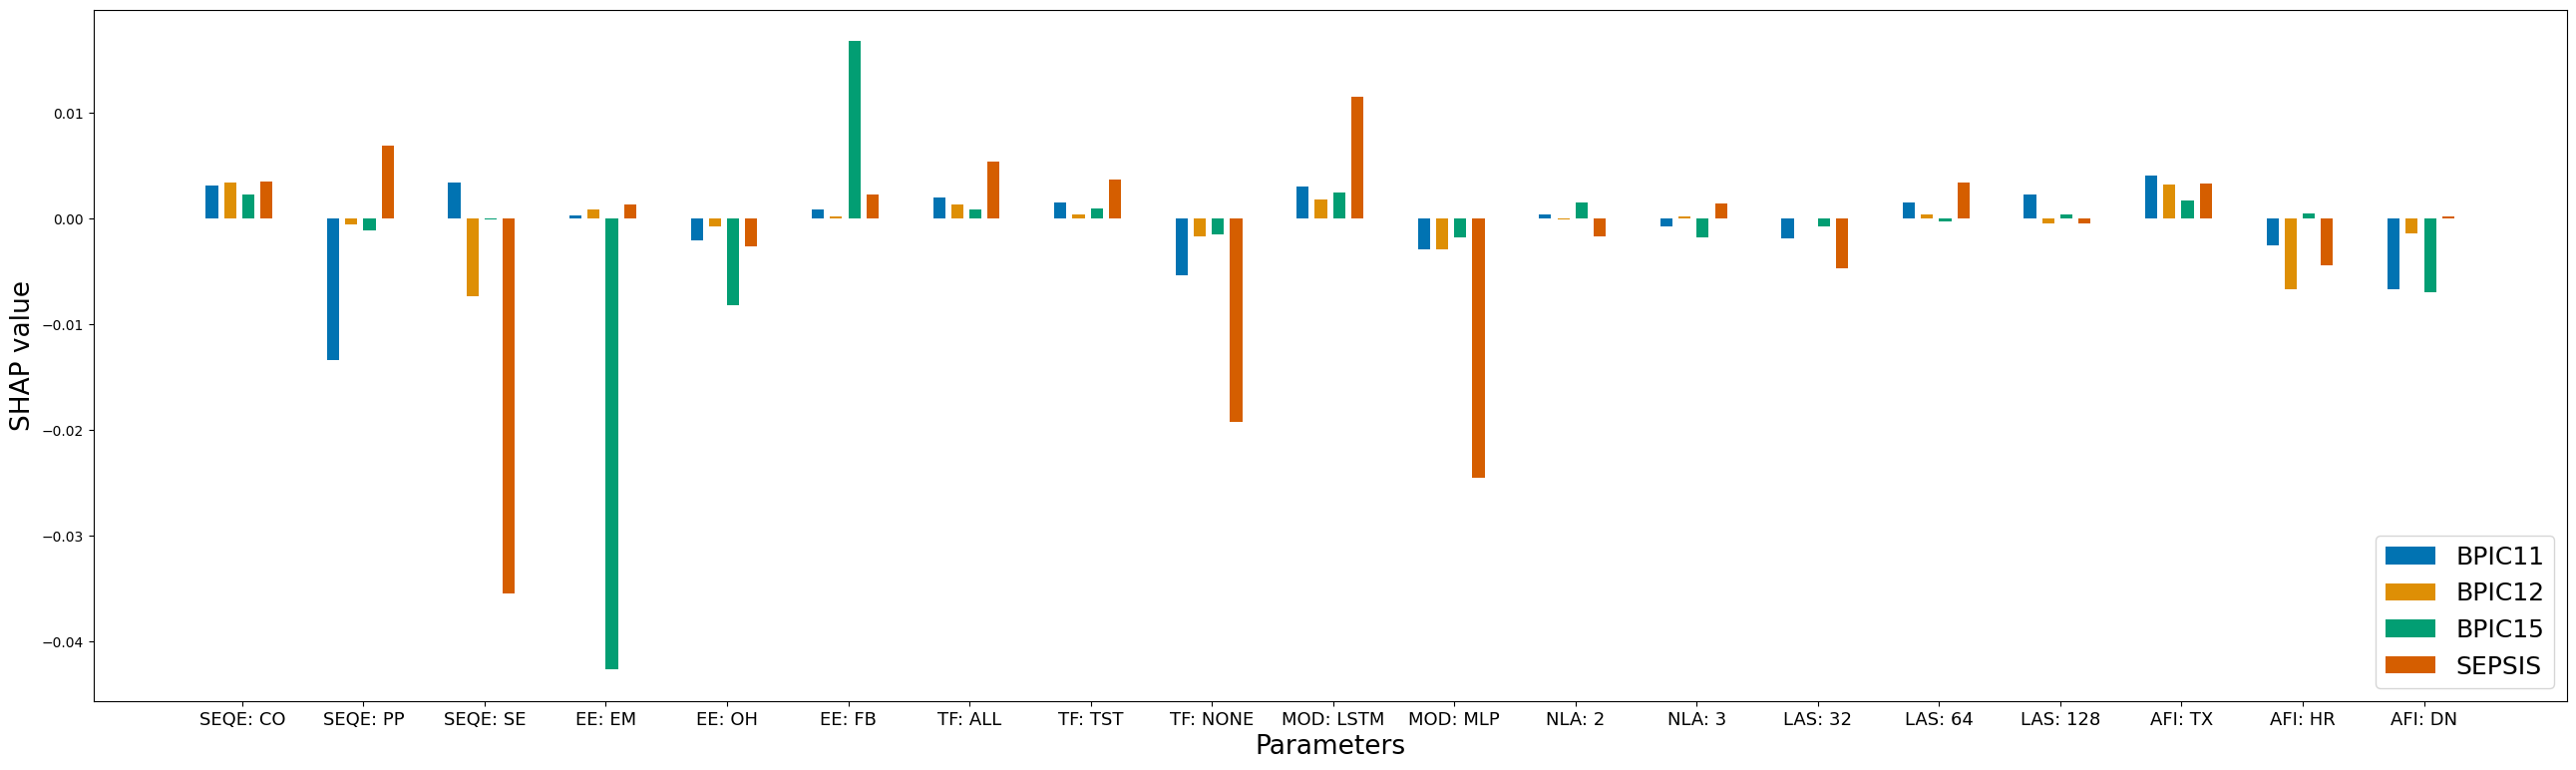

In [17]:
fig, ax = plt.subplots(figsize=(32,9))
bar_width = 0.1
index = np.arange(len(df_combined.index.tolist()))

for i in range(len(file_dir)):

    if i == 0:
        plt.bar(index + bar_width+0.1, df_combined.values[:,i], bar_width, alpha=1, color=colors_bin[i], label=file_tag[i])
    elif i==1:
        plt.bar(index + bar_width+0.25, df_combined.values[:,i], bar_width, alpha=1, color=colors_bin[i], label=file_tag[i])
    elif i==2:
        plt.bar(index + bar_width+0.4, df_combined.values[:,i], bar_width, alpha=1, color=colors_bin[i], label=file_tag[i])
    else:
        plt.bar(index + bar_width+0.55, df_combined.values[:,i], bar_width, alpha=1, color=colors_bin[i], label=file_tag[i])

plt.xticks(np.arange(bar_width+0.35, 19+ bar_width, 1), df_combined.index.tolist(),fontsize="13") # 16 if nextact
plt.xlabel('Parameters', size = 19)
plt.ylabel('SHAP value', size = 19)
plt.legend(loc='lower right',fontsize="18")
plt.show()

# EBM

## Preprocess

In [18]:

def df_concat_ebm(fd_):
    file_list = os.listdir(file_loc+str(fd_))
    df_list = []
    df_ = pd.DataFrame()

    for i in file_list:
        with open(file=(file_loc+str(fd_)+str(i)), mode='rb') as f:
            df =pickle.load(f)
        df=df[['Sequence', 'Event', 'Time', 'Models', 'NoLayer','NoHidden', 'Init+Actf','AUC_ovr']]
        df.columns = ['Sequence', 'Event', 'Time', 'Models', 'NoLayer','NoHidden', 'Init+Actf','AUC']
        df_ = pd.concat([df_,df], sort=False)
    df_.columns = ['SEQE', 'EE', 'TF', 'MOD', 'NLA','LAS', 'AFI','AUC']
    return df_

In [19]:
def ebmout(df_c):
  X = df_c.iloc[:,:-1]
  Y = df_c.iloc[:,-1]
  feature_types=['nominal','nominal','nominal','nominal','nominal','nominal','nominal']
  model = interpret.glassbox.ExplainableBoostingRegressor(interactions=45,random_state=42,feature_types=feature_types)
  model.fit(X, Y)
  return model

In [20]:
dfc_ebm_1 = []
value_mappings = {
    'cont': 'CO', 'prfx': 'PP', 'se': 'SE', 'emb': 'EM', 'oh': 'OH',
    'frq': 'FB', 'all': 'ALL', 'tssc_tsp': 'TST', 'none': 'NONE',
    'lstm': 'LSTM', 'mlp': 'MLP', 'xav+tanh': 'TX', 'he+relu': 'HR',
    'default+none': 'DN'
}
for fd in file_dir:
    df_concat = df_concat_ebm(fd)
    df_concat = df_concat.drop_duplicates()
    df_concat = df_concat.replace(value_mappings)
    dfc_ebm_1.append(df_concat)


## EBM Global

In [22]:
glob_imp_bin = {}
sing_imp_bin = {}
inter_imp_bin = {}
for el,tag in zip(dfc_ebm_1,file_tag):
    ebm_model = ebmout(el)
    exp_glob = ebm_model.explain_global()
    glob_importance = {}
    sing_importance = {}
    inter_importance = {}
    for n,s in zip(exp_glob.data()['names'],exp_glob.data()['scores']):
        glob_importance[n] = s
    glob_imp_bin[tag] = glob_importance
    for fi in range(7):
        for n,s in zip(exp_glob.data(fi)['names'],exp_glob.data(fi)['scores']):
            sing_importance[n] = s
    sing_imp_bin[tag] = sing_importance
    for fi in range(7,len(exp_glob.data()['names'])):
        for i,ln in enumerate(exp_glob.data(fi)['left_names']):
            for j,rn in enumerate(exp_glob.data(fi)['right_names']):
                #print(ln,"& ",rn, ': ', bpic11_glob.data(fi)['scores'][i,j])
                inter_importance[ln+"& "+rn] = exp_glob.data(fi)['scores'][i,j]
    inter_imp_bin[tag] = inter_importance



In [23]:
pd.DataFrame(glob_imp_bin)

,BPIC11,BPIC12,BPIC15,SEPSIS
SEQE,0.0049058,0.0028525,0.0011617,0.0104419
EE,0.0010717,0.0006169,0.0188856,0.0021435
TF,0.0026318,0.0010758,0.0011391,0.0079547
MOD,0.0029539,0.0022893,0.0020276,0.0144587
NLA,0.0005529,0.0001094,0.0015849,0.0015949
LAS,0.0018726,0.0002456,0.0004612,0.0028172
AFI,0.0039855,0.0033343,0.0024063,0.0028953
SEQE & EE,0.0006954,0.0012373,0.0082670,0.0005115
SEQE & TF,0.0005444,0.0002834,0.0007654,0.0053472
SEQE & MOD,0.0013554,0.0021332,0.0021382,0.0033640


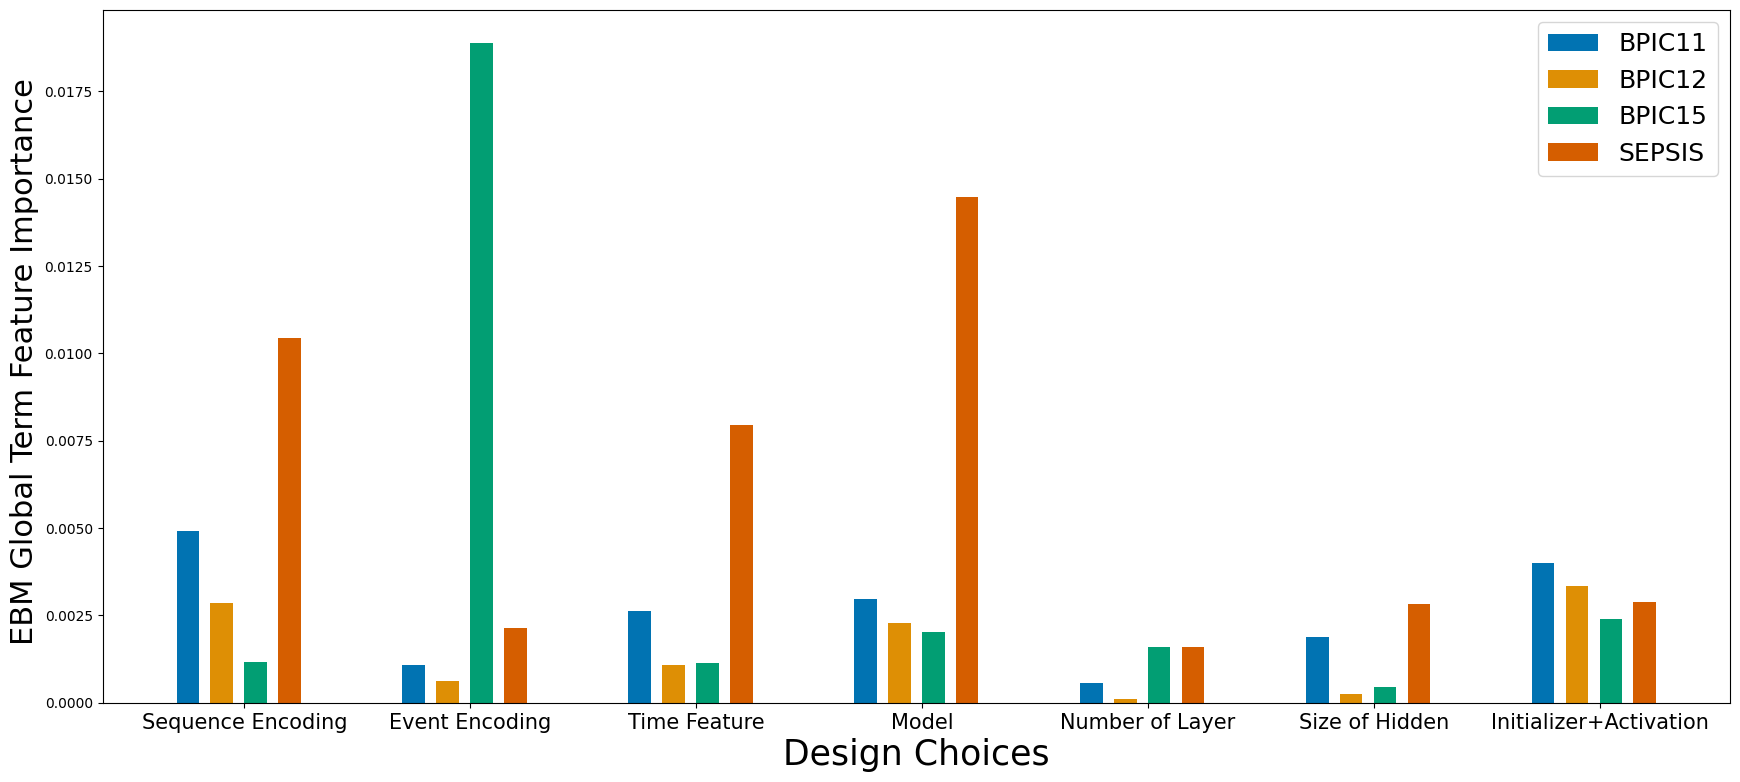

In [24]:
fig, ax = plt.subplots(figsize=(21,9))
bar_width = 0.1
ebm_glob_graph = [list(i.values())[:7] for i in list(glob_imp_bin.values())]
col_name = ['Sequence Encoding', 'Event Encoding', 'Time Feature', 'Model','Number of Layer', 'Size of Hidden', 'Initializer+Activation']
index = np.arange(len(col_name))

for i in range(len(file_dir)):

    if i == 0:
        plt.bar(index + bar_width+0.1, ebm_glob_graph[i], bar_width, alpha=1, color=colors_bin[i], label=file_tag[i])
    elif i==1:
        plt.bar(index + bar_width+0.25, ebm_glob_graph[i], bar_width, alpha=1, color=colors_bin[i], label=file_tag[i])
    elif i==2:
        plt.bar(index + bar_width+0.4, ebm_glob_graph[i], bar_width, alpha=1, color=colors_bin[i], label=file_tag[i])
    else:
        plt.bar(index + bar_width+0.55, ebm_glob_graph[i], bar_width, alpha=1, color=colors_bin[i], label=file_tag[i])

plt.xticks(np.arange(bar_width+0.35, len(col_name)+ bar_width, 1), col_name,fontsize="15") # 4 or
plt.xlabel('Design Choices', size = 25)
plt.ylabel('EBM Global Term Feature Importance ', size = 22)
plt.legend(fontsize="18")
plt.show()

## EBM Individual Contribution

In [25]:
pd.DataFrame(sing_imp_bin)

,BPIC11,BPIC12,BPIC15,SEPSIS
CO,0.0028004,0.0033874,0.0022706,0.0036306
PP,-0.0137539,-0.0006208,-0.0010917,0.0069725
SE,0.0030746,-0.0073774,-0.0000958,-0.0353418
EM,0.0004791,0.0009285,-0.0430041,0.0015460
FB,0.0010450,0.0002649,0.0164057,0.0024414
OH,-0.0019121,-0.0006585,-0.0085691,-0.0024819
ALL,0.0019633,0.0013190,0.0008400,0.0062306
NONE,-0.0054367,-0.0017033,-0.0015306,-0.0184214
TST,0.0014889,0.0004194,0.0009670,0.0044935
LSTM,0.0030918,0.0019593,0.0026026,0.0100186


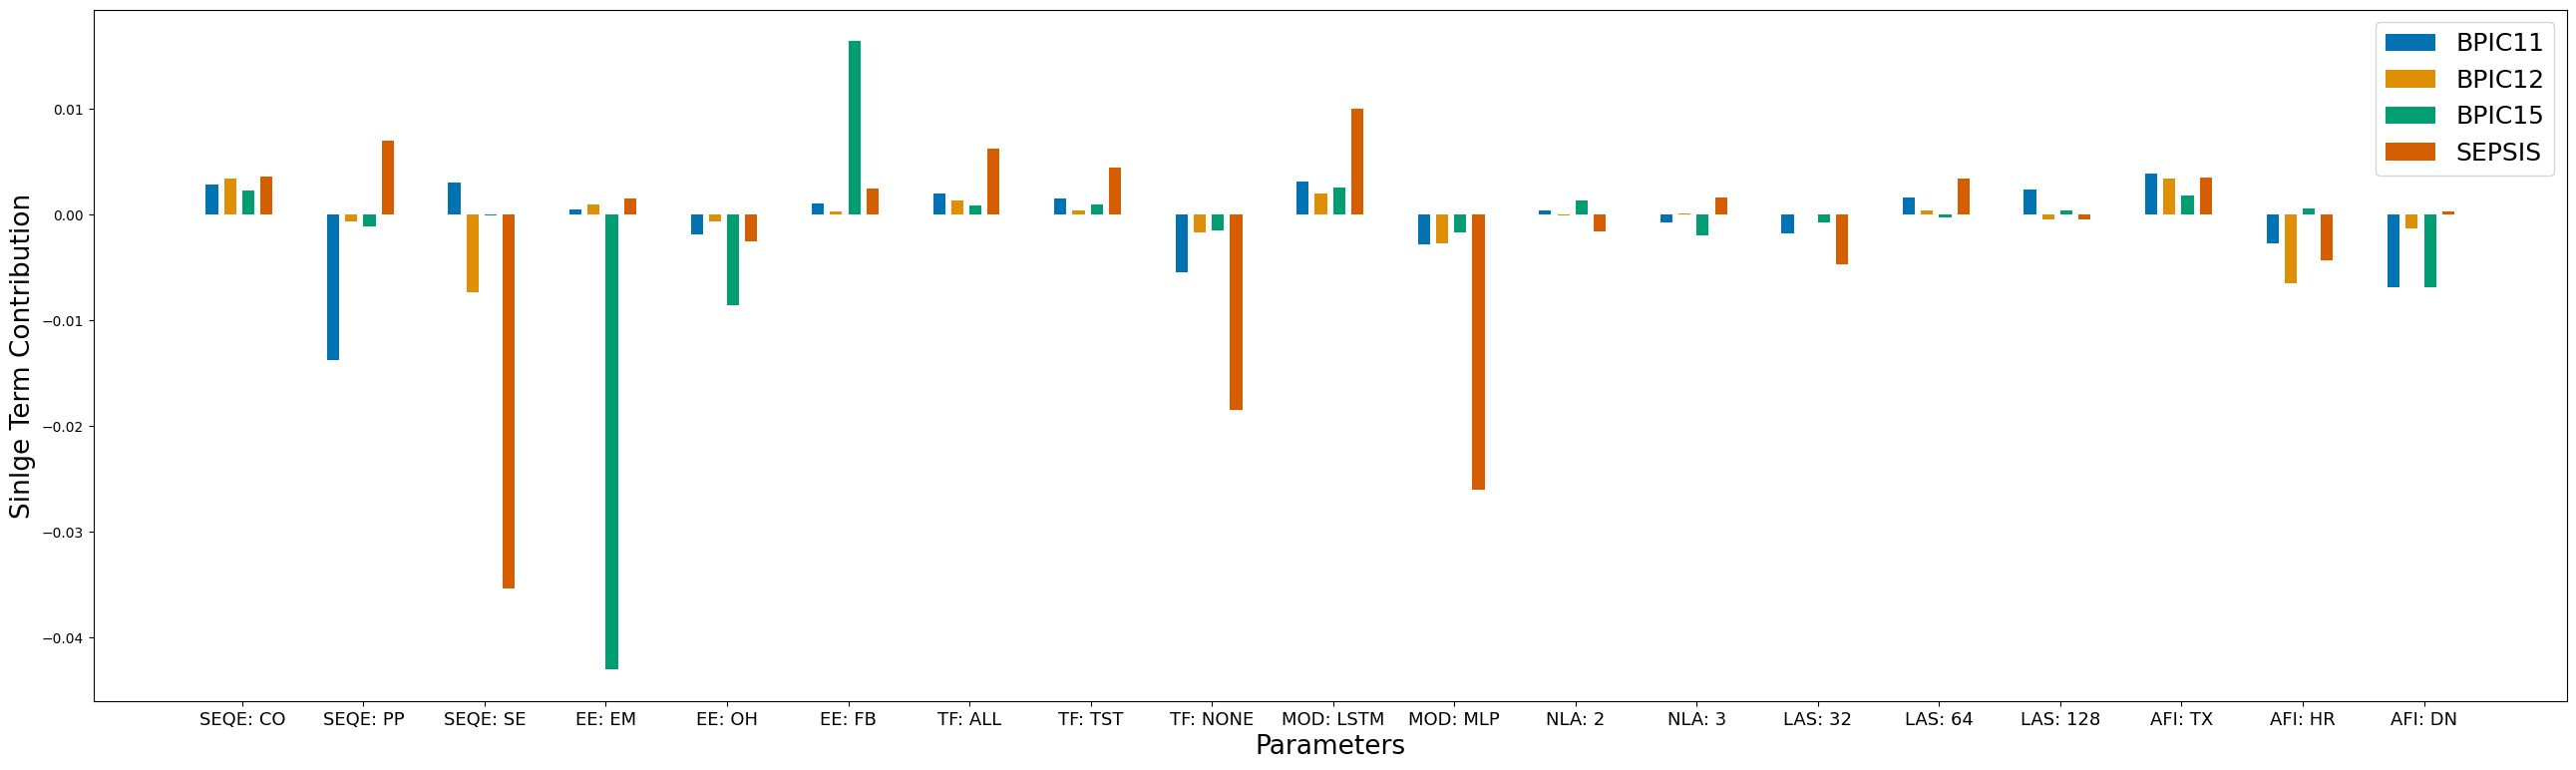

In [26]:
fig, ax = plt.subplots(figsize=(32,9))
bar_width = 0.1
index = np.arange(len(df_combined.index.tolist()))
ebm_sing_graph = pd.DataFrame(sing_imp_bin)
new_idx_order = ['CO','PP','SE','EM','OH','FB','ALL','TST','NONE','LSTM','MLP','2','3','32','64','128','TX','HR','DN']
ebm_sing_graph = ebm_sing_graph.reindex(new_idx_order)
ebm_sing_graph.index = ['SEQE: CO','SEQE: PP','SEQE: SE','EE: EM','EE: OH','EE: FB', 'TF: ALL','TF: TST','TF: NONE','MOD: LSTM','MOD: MLP','NLA: 2','NLA: 3','LAS: 32','LAS: 64','LAS: 128','AFI: TX','AFI: HR','AFI: DN']

for i in range(len(file_dir)):

    if i == 0:
        plt.bar(index + bar_width+0.1, ebm_sing_graph.values[:,i], bar_width, alpha=1, color=colors_bin[i], label=file_tag[i])
    elif i==1:
        plt.bar(index + bar_width+0.25, ebm_sing_graph.values[:,i], bar_width, alpha=1, color=colors_bin[i], label=file_tag[i])
    elif i==2:
        plt.bar(index + bar_width+0.4, ebm_sing_graph.values[:,i], bar_width, alpha=1, color=colors_bin[i], label=file_tag[i])
    else:
        plt.bar(index + bar_width+0.55, ebm_sing_graph.values[:,i], bar_width, alpha=1, color=colors_bin[i], label=file_tag[i])

plt.xticks(np.arange(bar_width+0.35, 19+ bar_width, 1), ebm_sing_graph.index.tolist(),fontsize="13") # 16 if nextact
plt.xlabel('Parameters', size = 19)
plt.ylabel('Sinlge Term Contribution', size = 19)
plt.legend(fontsize="18")
plt.show()

## EBM Pair-Wise Interaction Contribution

In [27]:
pd.DataFrame(inter_imp_bin)

,BPIC11,BPIC12,BPIC15,SEPSIS
CO& EM,0.0002225,-0.0009457,-0.0075125,0.0000807
CO& FB,-0.0007221,-0.0016536,0.0021720,-0.0024762
CO& OH,0.0011575,0.0007736,0.0018056,0.0004790
PP& EM,-0.0005807,0.0009591,-0.0101953,-0.0001676
PP& FB,0.0018990,0.0016843,0.0065758,0.0008111
PP& OH,-0.0044952,-0.0016594,-0.0097488,0.0003146
SE& EM,0.0000599,0.0001134,0.0361857,-0.0011054
SE& FB,-0.0004224,-0.0007342,-0.0143156,-0.0005420
SE& OH,0.0004800,0.0019247,0.0074697,-0.0007268
CO& ALL,-0.0004920,0.0000964,-0.0029418,-0.0001324
